## ChestX-Ray 14 Dataset

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

from src.cxr14 import CXR14

(ds_train, ds_test), ds_info = tfds.load(
    'cx_r14',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

2021-11-14 17:23:09.338086: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-14 17:23:09.390272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-14 17:23:09.390641: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-14 17:23:09.391249: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow wi

### Simple Build Pipeline

In [2]:
def preproc_img(image, label):
  image = tf.image.resize(image, [224, 224])
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    preproc_img, num_parallel_calls=tf.data.AUTOTUNE)
#ds_train = ds_train.shuffle(buffer_size=1000)
ds_train = ds_train.batch(8)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [3]:
ds_test = ds_test.map(
    preproc_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(8)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

### Benchmark

In [4]:
tfds.benchmark(ds_train, batch_size=8)

### Visualization

2021-11-14 17:23:10.630275: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(224, 224, 3) (14,)
(224, 224, 3) (14,)
(224, 224, 3) (14,)
(224, 224, 3) (14,)
(224, 224, 3) (14,)
(224, 224, 3) (14,)
(224, 224, 3) (14,)
(224, 224, 3) (14,)


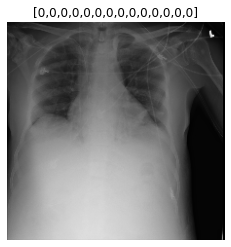

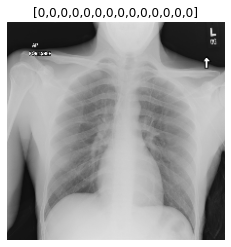

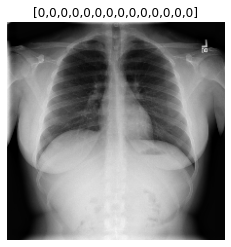

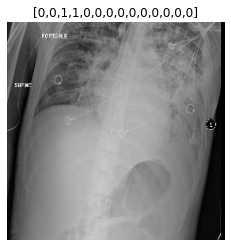

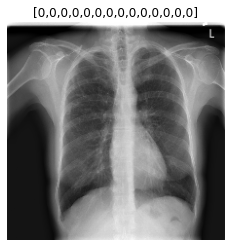

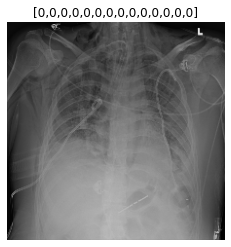

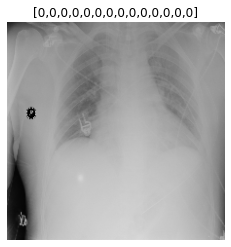

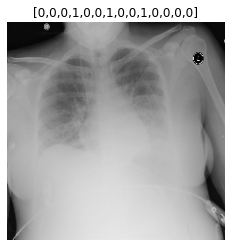

In [5]:
import matplotlib.pyplot as plt
import numpy as np

#tfds.show_examples(ds_train, ds_info)
def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(np.array2string(label.numpy(), separator=','))
  plt.axis('off')
   
for image, label in ds_train.take(1).unbatch():
  print(image.shape, label.shape)
  show(image, label)

## Train

In [6]:
model = tf.keras.models.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(224, 224, 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(14, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.AUC(curve='ROC',multi_label=True, num_labels=14, from_logits=False)],
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0

In [7]:
model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

Epoch 1/6


2021-11-14 17:23:14.096765: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2021-11-14 17:23:14.414583: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 7533/13034 [================>.............] - ETA: 4:04 - loss: 518913064960.0000 - auc: 0.4999

KeyboardInterrupt: 